In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib as jb
import math
import cv2
import matplotlib.patches as mpatches
import colorsys
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns

In [17]:
sns.set_style('darkgrid')

# Visualization - Bands and CSPM

In [18]:
data_path = 'generated/'
charts_path = 'generated/charts/'
maps_path = 'generated/maps/'
models_path = 'generated/models/'

# Load models

In [19]:
rf_model = jb.load(f'{models_path}rf_model.pkl.z')
lgbm_model = jb.load(f'{models_path}lgbm_model.pkl.z')
mlp_model = jb.load(f'{models_path}mlp_model.pkl.z')
xgboost_model = jb.load(f'{models_path}xgboost_model.pkl.z')
lr_model = jb.load(f'{models_path}lr_model.pkl.z')


In [20]:
df_bat = jb.load(f'{data_path}bat_dataframe.pkl.z')
df = jb.load(f'{data_path}dataset_dataframe.pkl.z')

In [21]:
base_image = cv2.imread(f'{maps_path}rgb_image.jpg')

In [22]:
columns = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']

In [23]:
transects_image = base_image.copy()
for i, row in enumerate(df.itertuples()):
    x = row.x
    y = row.y
    transects_image = cv2.circle(transects_image,(x,y),4,[255,255,255],4)
cv2.imwrite(f'{maps_path}bat_transects.jpg',transects_image)

True

In [24]:
# dataframe requires: x, y, error
def draw_abs_error_image(rgb_base, dataframe, prefix, divisor=30):
    result_image = rgb_base.copy()
    for i, row in enumerate(dataframe.itertuples()):
        x = int(row.x)
        y = int(row.y)
        abs_error = row.abs_error
        result_image = cv2.circle(result_image,(x,y),5,[int(e*255) for e in (colorsys.hls_to_rgb(min(0.8,abs_error/float(divisor)), 0.5, 1))],6)
        #abs_error_image[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(abs_error/(df_data['abs_error'].max()*1.2), 0.5, 1))]

    result = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    result_label = insert_label(result,'Error',divisor)
    cv2.imwrite(f'{maps_path}{prefix}/abs_error.jpg',result_label)
    

In [25]:
# dataframe requires: x, y, z or predict
def draw_depth_image(rgb_base, dataframe, prefix, isbat=True, divisor=30):
    result_image = rgb_base.copy()
    for i, row in enumerate(dataframe.itertuples()):
        x = int(row.x)
        y = int(row.y)
        depth = 0
        if isbat:
            depth = row.z
        else:
            depth = row.prediction
        
        result_image = cv2.circle(result_image,(x,y),5,[int(e*255) for e in (colorsys.hls_to_rgb(min(0.8,depth/float(divisor)), 0.5, 1))],5)
        #abs_error_image[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(abs_error/(df_data['abs_error'].max()*1.2), 0.5, 1))]

    result = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    result_label = insert_label(result,'Depth',divisor)
    cv2.imwrite(f'{maps_path}{prefix}/{"bat" if isbat else "prediction"}_depth.jpg',result_label)

In [26]:
def insert_label(image,label,max_depth_value=30):
    frame = image.copy()
    posx = 0.80
    posy = 0.5
    height = 0.4
    width = 0.15
    spacing = 5
    intervals = 10

    h = int(image.shape[0]*height)
    w = int(image.shape[1]*width)
    x = int(image.shape[1]*posx)
    y = int(image.shape[0]*posy)
    cv2.rectangle(frame, (x, y), (x+w,y+h), (255, 255, 255), -1)

    cv2.rectangle(frame, (x, y-300), (x+w,y), (255, 255, 255), -1)


    font = cv2.FONT_HERSHEY_COMPLEX
    fontScale = 3
    color = (0, 0, 0)
    thickness = 4
    pos = (x+50, y-180)
    cv2.putText(frame, label, pos, font, fontScale, color, thickness, cv2.LINE_AA)
    pos = (x+50, y-100)
    fontScale = 2
    cv2.putText(frame, "(meters)", pos, font, fontScale, color, thickness, cv2.LINE_AA)

    fontScale = 2
    for i in range(intervals+1):
        pos = (x+250, y-15+int(i*h/intervals))
        cv2.putText(frame, str(i*max_depth_value/float(intervals)), pos, font, fontScale, color, thickness, cv2.LINE_AA)

    iterations = max_depth_value*100
    for i in range(iterations):
        color = [int(e*255) for e in (colorsys.hls_to_rgb(0.8*((i)/100)/max_depth_value, 0.5, 1))]
        cv2.rectangle(frame, (x+50, y-40+int(h*(i/iterations))), (x+int(w/2.5),y-40+int(h*(i/iterations))+1), color[::-1], -1)

    return frame

In [27]:
def find_transect(x_s, y_s, x_e, y_e, df):
    transect = list()
    angle = math.atan2(y_s-y_e, x_s-x_e)
    low_x, high_x = (x_s, x_e) if x_s < x_e else (x_e, x_s)
    low_y, high_y = (y_s, y_e) if y_s < y_e else (y_e, y_s)
    df_t = df[(df['x'] >= low_x) & (df['x'] <= high_x)]
    df_t = df_t[(df_t['y'] >= low_y) & (df_t['y'] <= high_y)]
    for row in df_t.itertuples():
        x = row.x 
        y = row.y
        angle2 = math.atan2(y-y_e,x-x_e)
        #math.atan2(y-y_s,x-x_s)
        if abs(angle2 - angle) < 0.05:
            transect.append(row)
    return transect
    

In [28]:
def generate_transect_charts(dfprediction, df_bat, df_val, coords, charts_path, maps_path, base_image, prefix):
    transect = find_transect(coords[0],coords[1],coords[2],coords[3],dfprediction)
    bat_transect = find_transect(coords[0],coords[1],coords[2],coords[3],df_bat)
    
    if base_image is not None:
        transect_image = base_image.copy()
        for i, row in enumerate(transect):
            x = row.x
            y = row.y
            transect_image = cv2.circle(transect_image,(x,y),5,[0,255,0],5)

        cv2.imwrite(f'{maps_path}bat_single_transect_{coords[0]}_{coords[1]}.jpg',transect_image)
        
    df_transect = pd.DataFrame(transect)
    df_transect.drop(['Index'], axis=1, inplace=True)
    
    df_transect_bat = pd.DataFrame(bat_transect)
    df_transect_bat.drop(['Index'], axis=1, inplace=True)
    
    plt.figure(figsize=(15,8))
    plt.plot(df_transect_bat['x'],-df_transect_bat['z'], 'c.',
             df_transect['x'],-df_transect['z'], 'b.')
    a = mpatches.Patch(color='c', label='Bathymetry')
    b = mpatches.Patch(color='b', label='Bathymetry Pixel')
    plt.legend(handles=[a,b])
    plt.xlabel("X Pixel Coord")
    plt.ylabel("Depth(m)")
    plt.savefig(f'{charts_path}{prefix}/chart_bat_pixel_{coords[0]}_{coords[1]}.jpg')
    
    plt.figure(figsize=(15,8))
    plt.plot(df_transect_bat['x'],-df_transect_bat['z'], 'c.',
             df_transect['x'],-df_transect['prediction'], 'm.')
    a = mpatches.Patch(color='c', label='Bathymetry')
    b = mpatches.Patch(color='m', label='Prediction All')
    plt.legend(handles=[a,b])
    plt.xlabel("X Pixel Coord")
    plt.ylabel("Depth(m)")
    plt.savefig(f'{charts_path}{prefix}/chart_bat_pred_{coords[0]}_{coords[1]}.jpg')
    
    plt.figure(figsize=(15,8))
    plt.plot(df_transect_bat['x'],-df_transect_bat['z'], 'c.',
             df_transect[df_transect.index.isin(df_val.index)]['x'],-df_transect[df_transect.index.isin(df_val.index)]['prediction'], 'r.')
    a = mpatches.Patch(color='c', label='Bathymetry')
    b = mpatches.Patch(color='r', label='Prediction Val')
    plt.legend(handles=[a,b])
    plt.xlabel("X Pixel Coord")
    plt.ylabel("Depth(m)")
    plt.savefig(f'{charts_path}{prefix}/chart_bat_pred_val_{coords[0]}_{coords[1]}.jpg')

In [29]:
transect_coords = [[510,410,680,310],
                   [1604,142,1772,440],
                   [871,1123,1190,939],
                   [1020,705,1319,532],
                   [706,1338,1028,1149],
                   [1366,935,1130,523],
                   [1081,1090,1020,983],
                   [510,294,617,233]]

#p2: 706 1338, 1028 1149
#p3: 1366 935, 1130 523
#p4: 1081 1090, 1020 983
#p5: 494 417, 689 303

In [32]:
def generate_maps_and_charts(model, df, df_bat, columns, base_image, model_name, transect_coords, charts_path, maps_path):
    X_train, X_val, y_train, y_val = train_test_split(df[columns], df.z, test_size=0.3, random_state=42)
    prediction = model.predict(df[columns])
    prediction_val = model.predict(X_val)
    dfpred = df[['x','y','z']].copy()
    dfpred['prediction'] = prediction
    dfpred['abs_error'] = abs(dfpred['prediction'] - dfpred['z'])
    draw_abs_error_image(base_image,dfpred,model_name,10)
    draw_depth_image(base_image,dfpred,model_name,False)
    draw_depth_image(base_image,dfpred,model_name)
    #plt.grid()
    for i, coords in enumerate(transect_coords):
        generate_transect_charts(dfpred, df_bat, X_val, coords, charts_path, maps_path, base_image, model_name)

C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


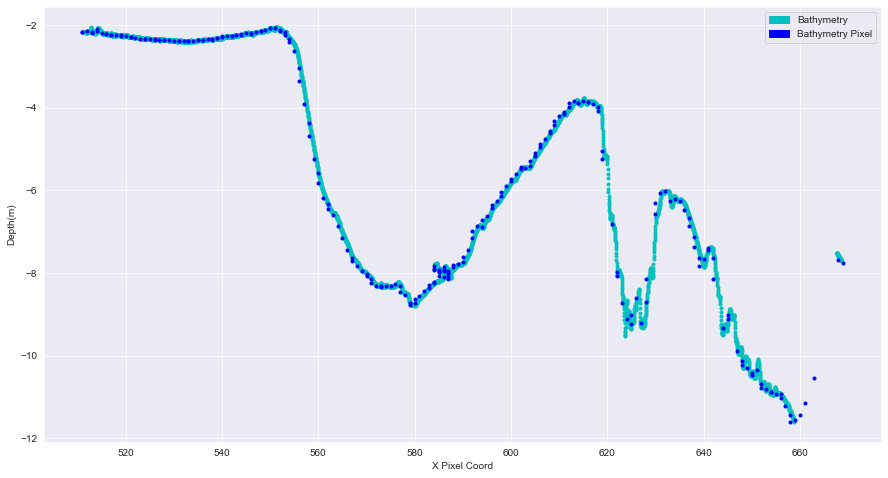

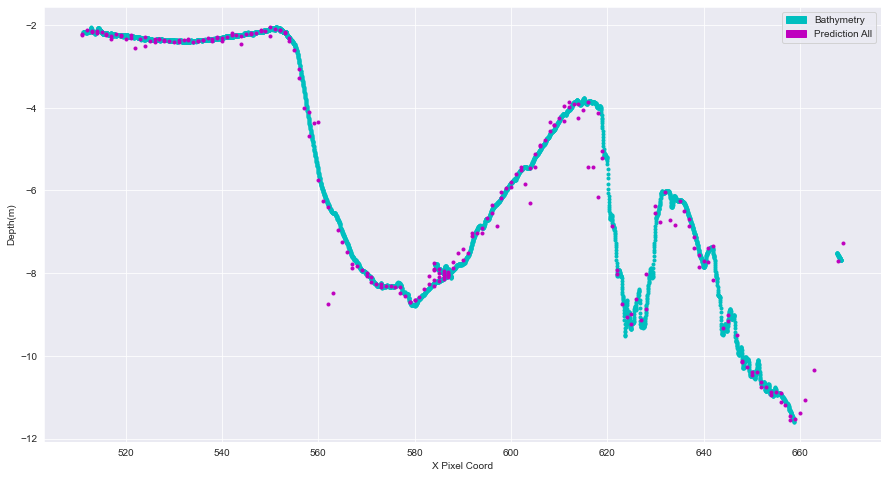

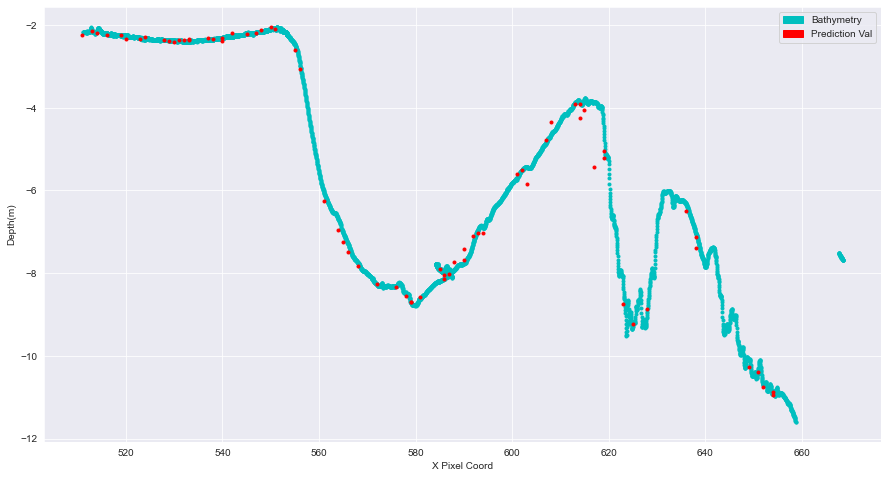

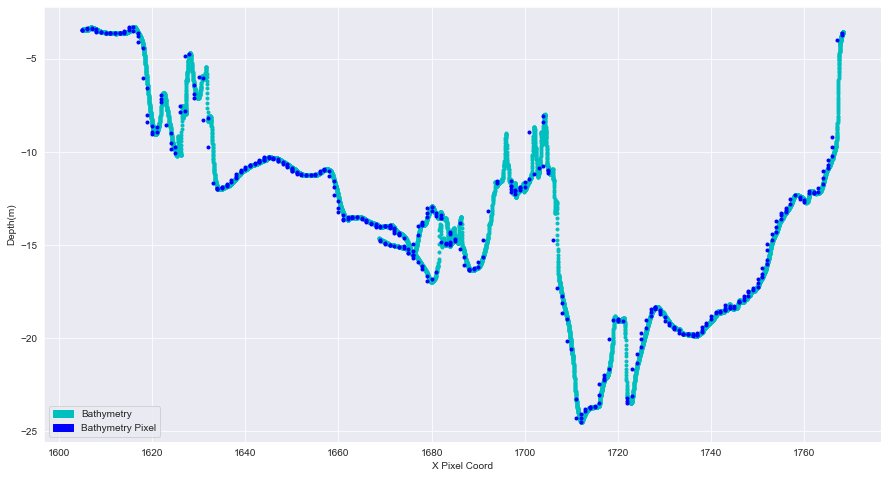

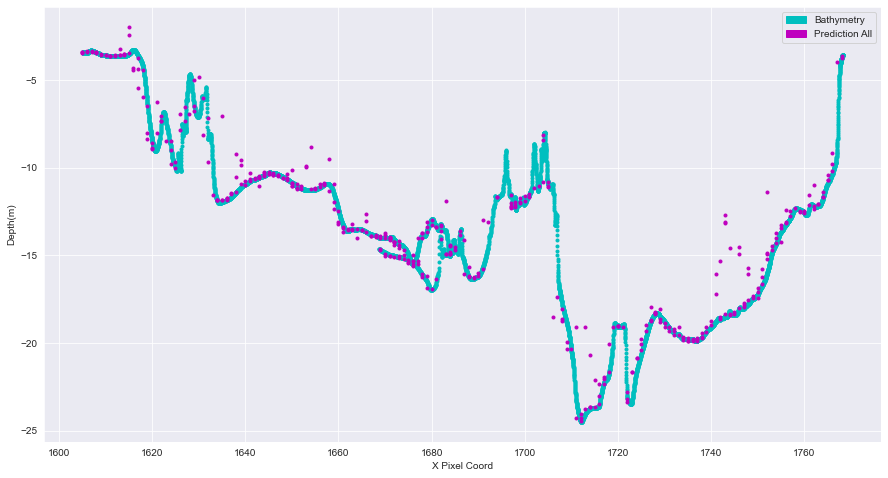

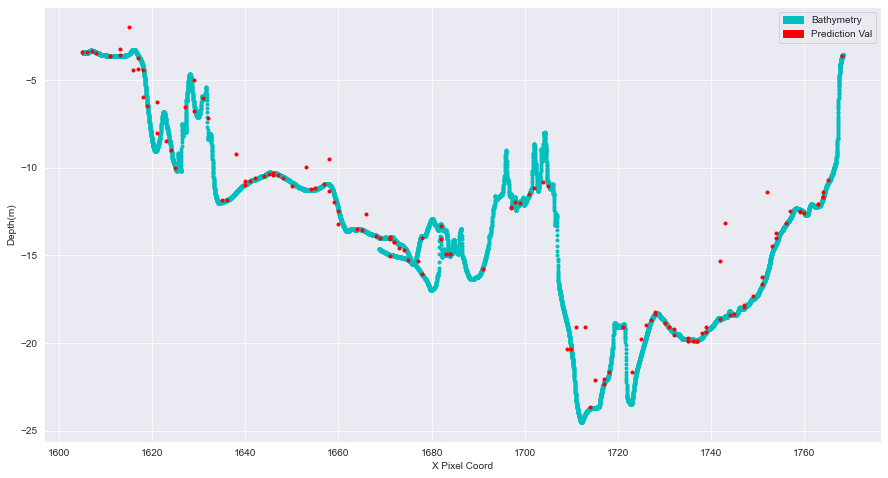

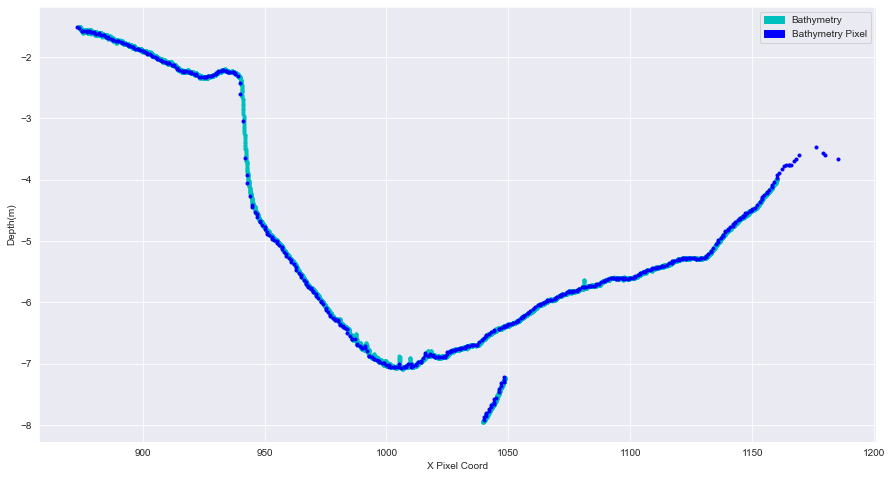

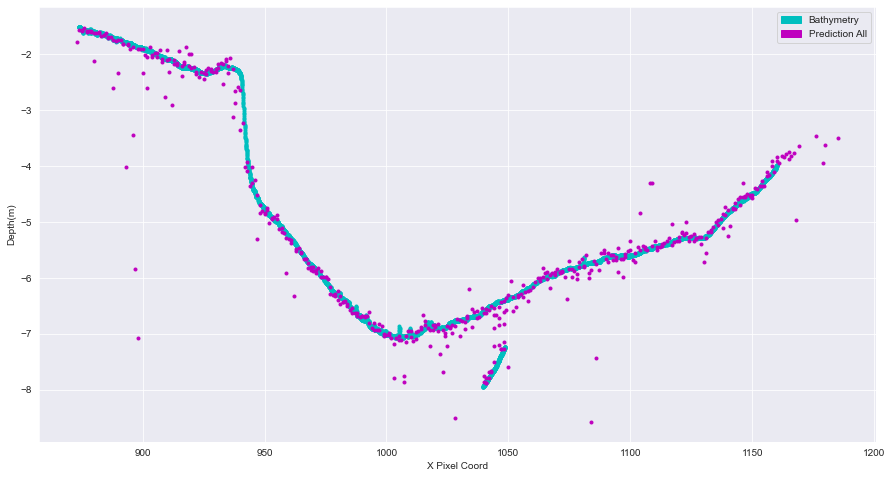

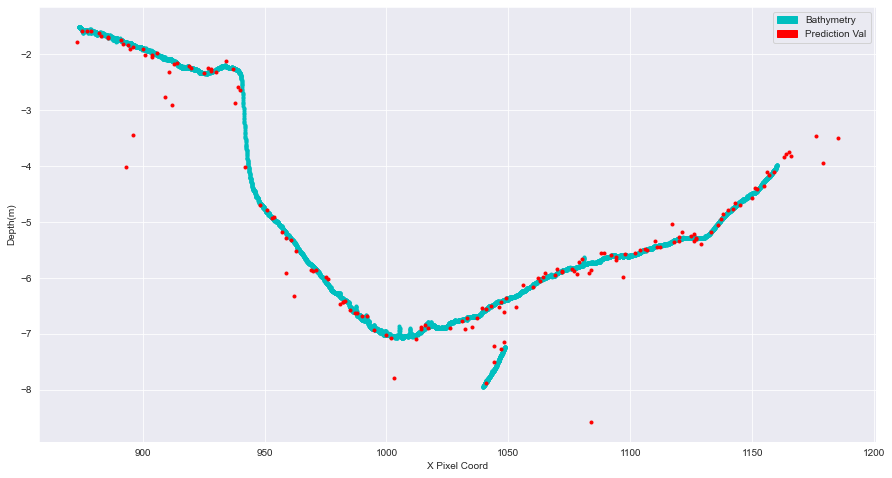

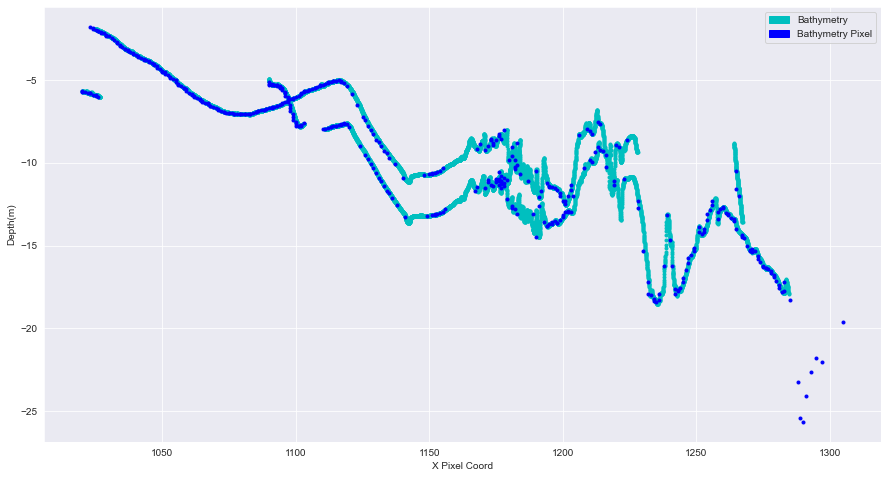

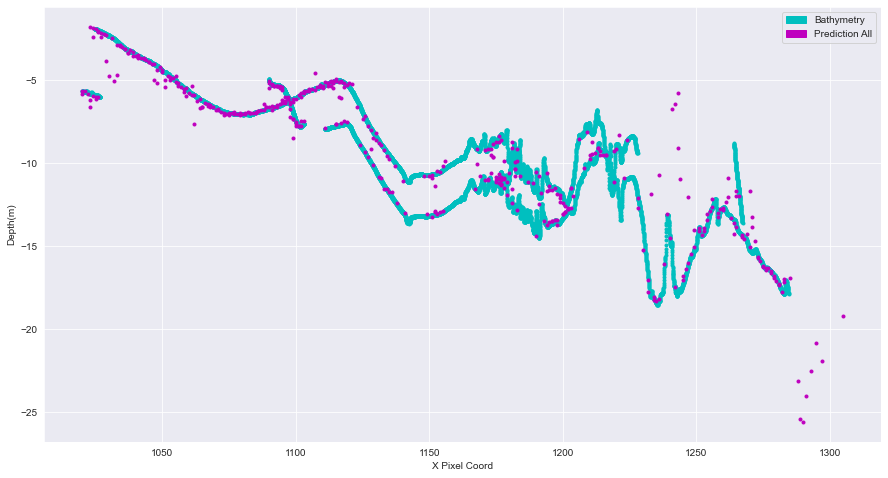

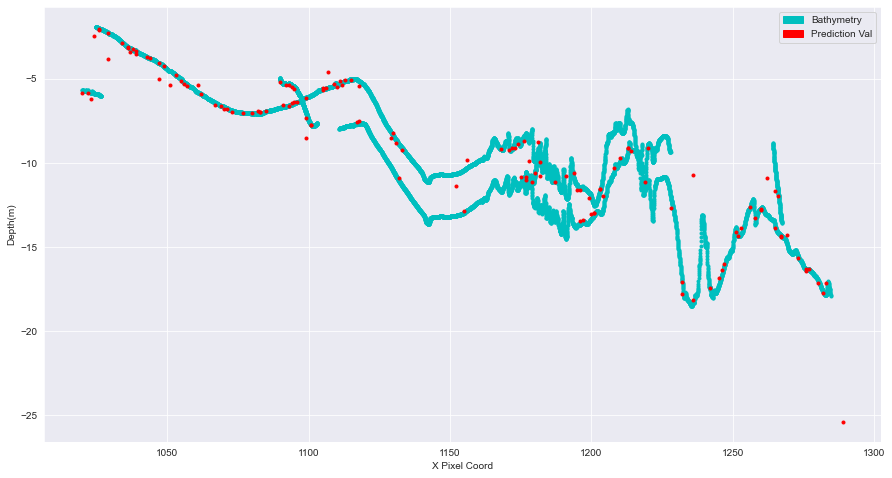

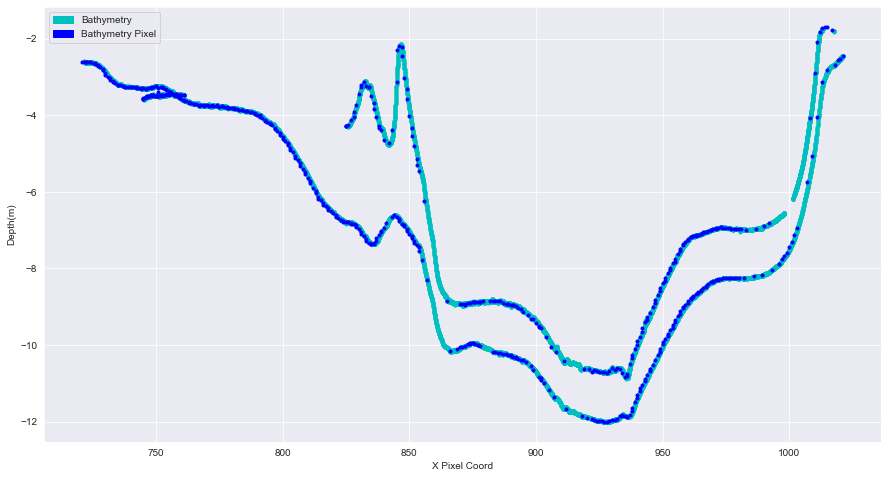

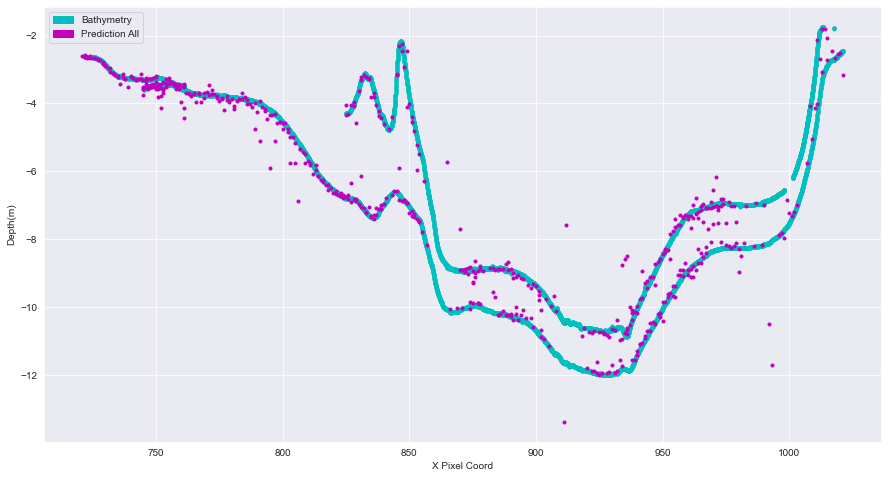

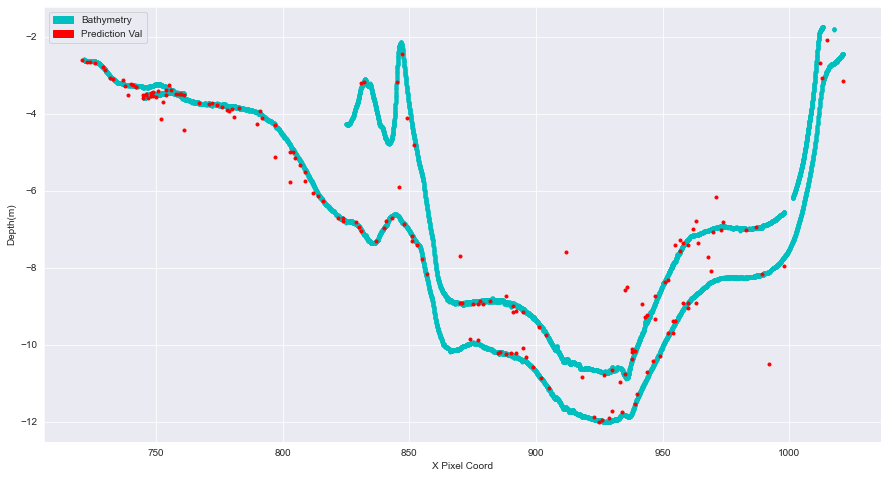

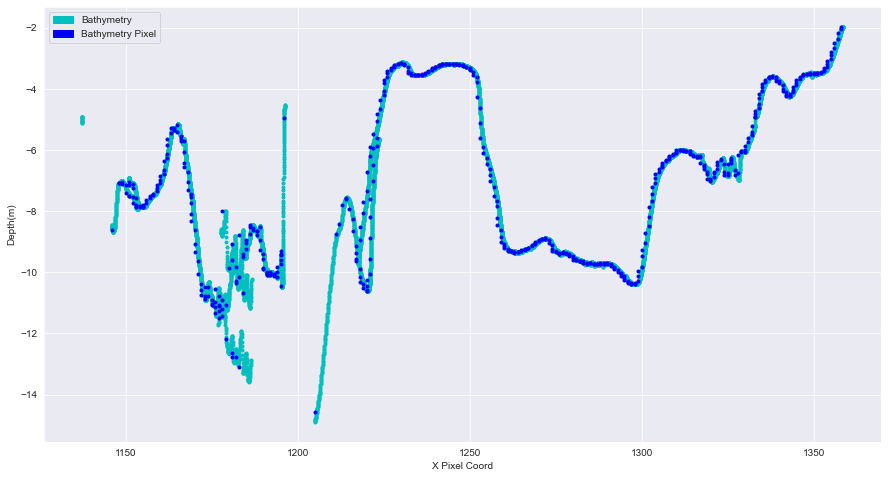

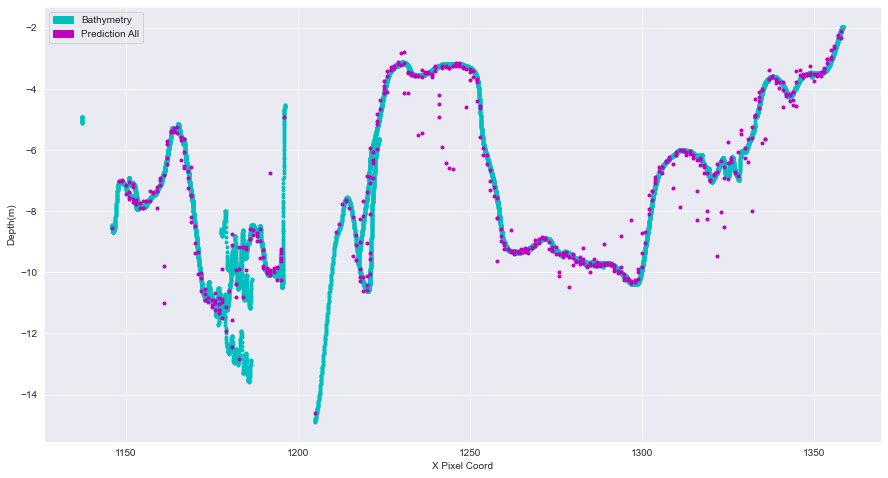

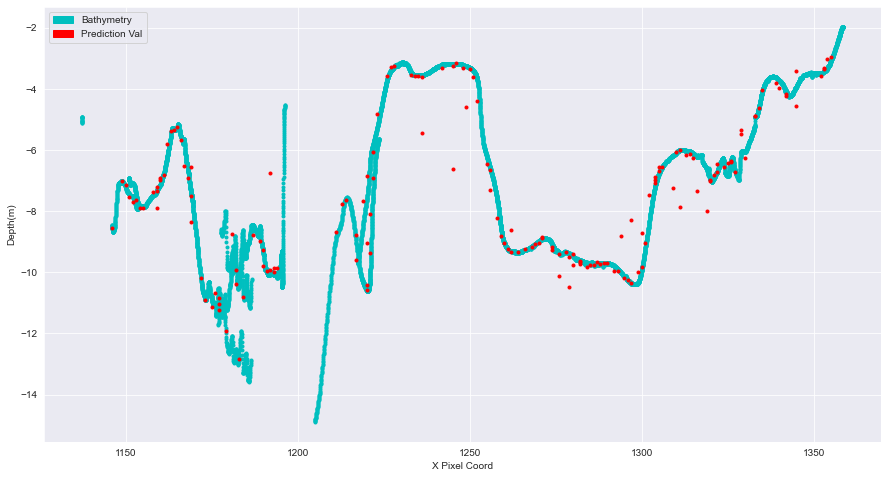

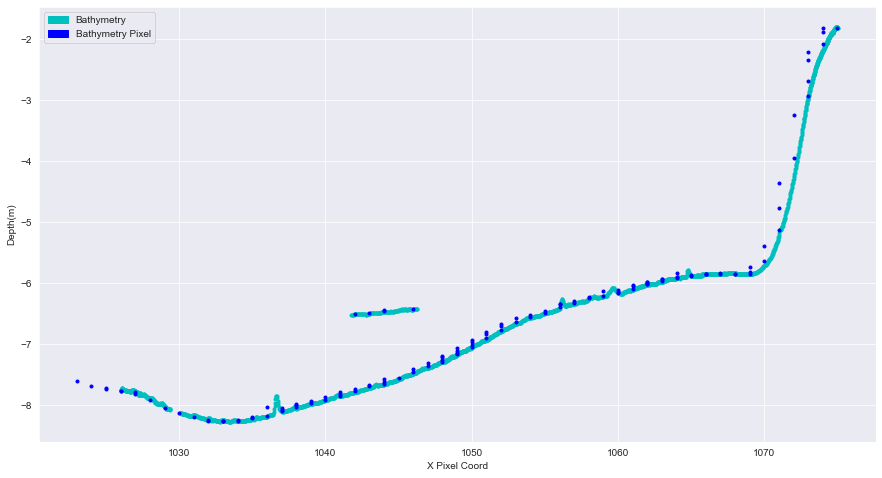

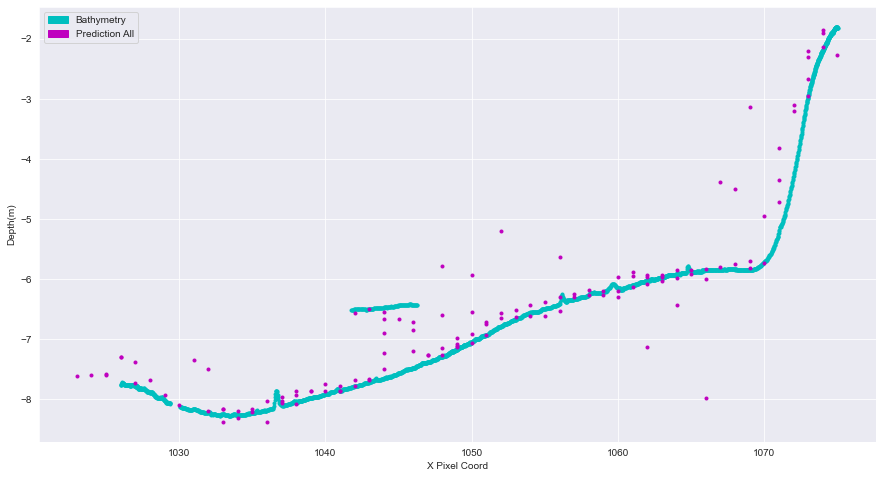

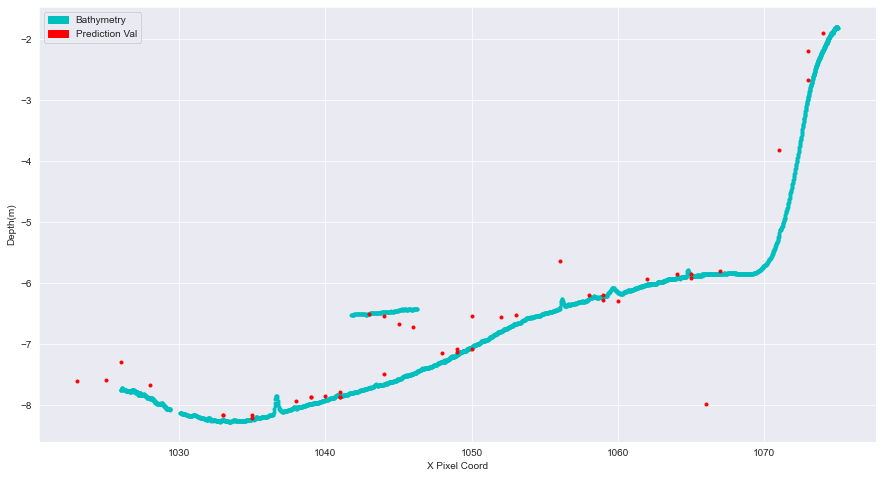

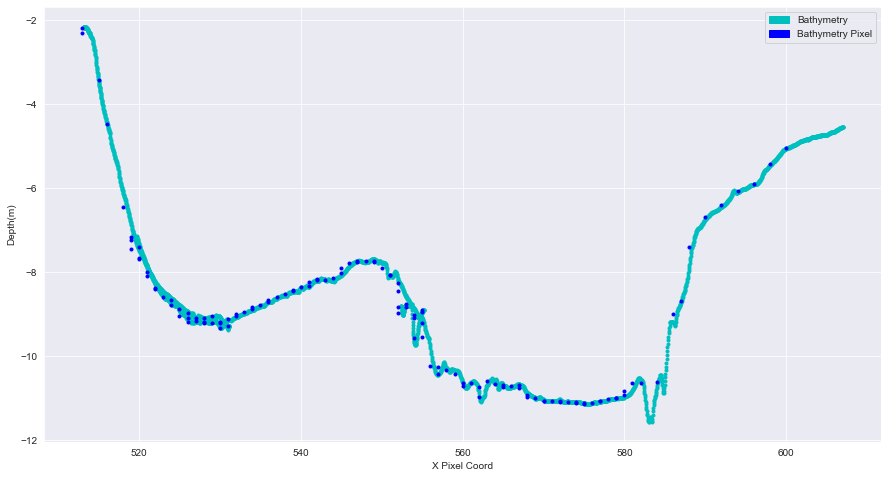

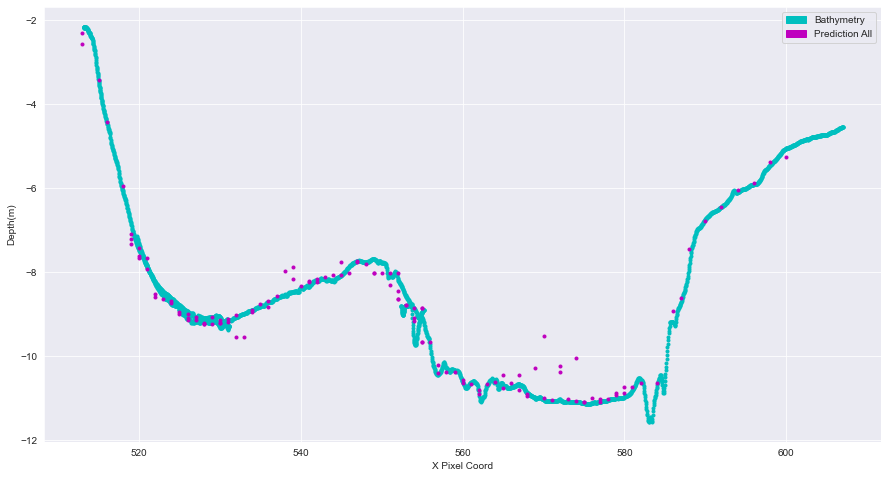

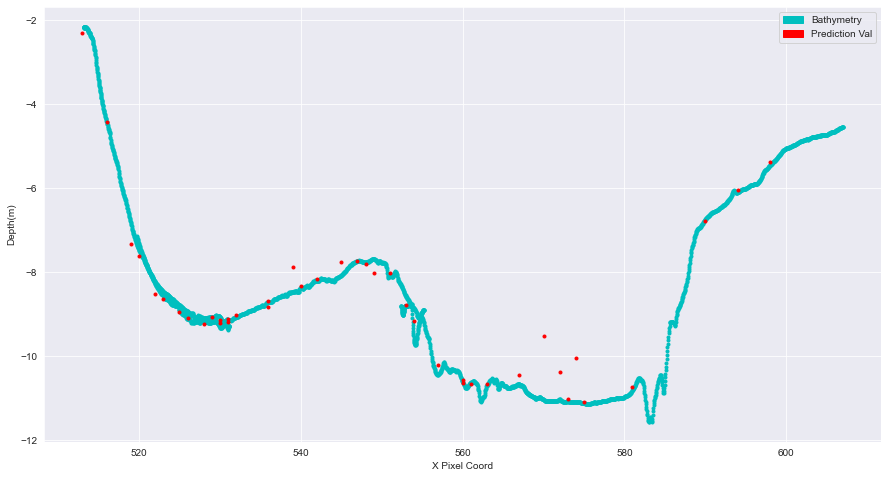

In [35]:
generate_maps_and_charts(lgbm_model, df, df_bat, columns, base_image, 'lgbm', transect_coords, charts_path, maps_path)